Average NLL over the last 100 samples at step 0: -0.00000
Average NLL over the last 100 samples at step 100: 399.28052
Average NLL over the last 100 samples at step 200: 245.29609
Average NLL over the last 100 samples at step 300: 369.81041
Average NLL over the last 100 samples at step 400: 35.37799
Average NLL over the last 100 samples at step 500: 248.63028
Average NLL over the last 100 samples at step 600: 75.75702
Average NLL over the last 100 samples at step 700: 174.62392
Average NLL over the last 100 samples at step 800: 60.70510
Average NLL over the last 100 samples at step 900: 242.32597
Average NLL over the last 100 samples at step 1000: 113.61659
Average NLL over the last 100 samples at step 1100: 87.44999
Average NLL over the last 100 samples at step 1200: 231.05934
Average NLL over the last 100 samples at step 1300: 56.97420
Average NLL over the last 100 samples at step 1400: 148.91907
Average NLL over the last 100 samples at step 1500: 78.78793


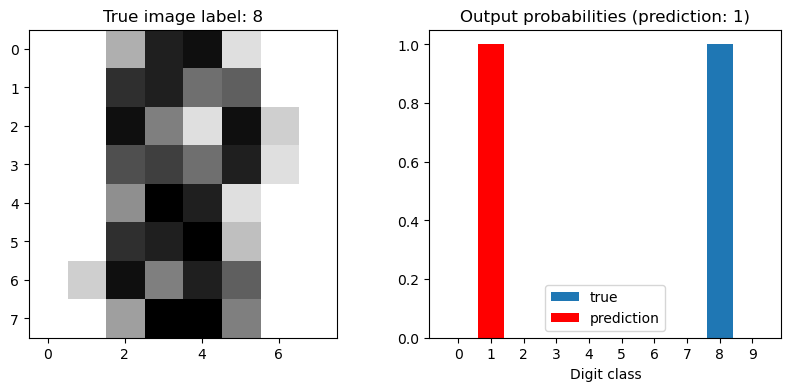

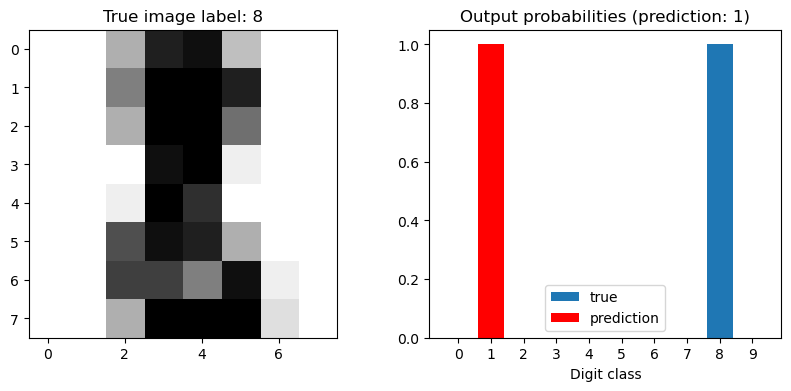

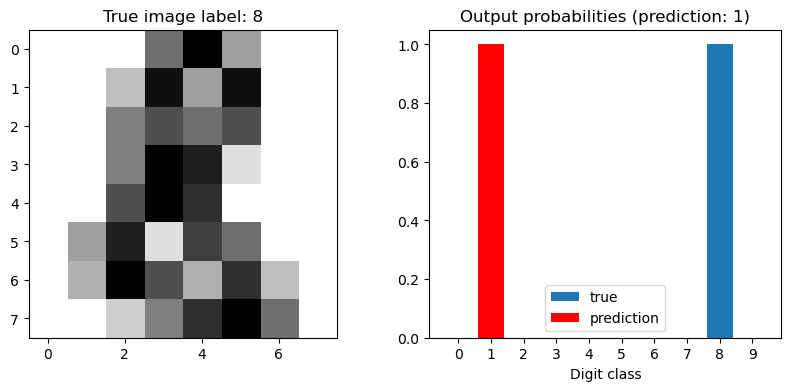

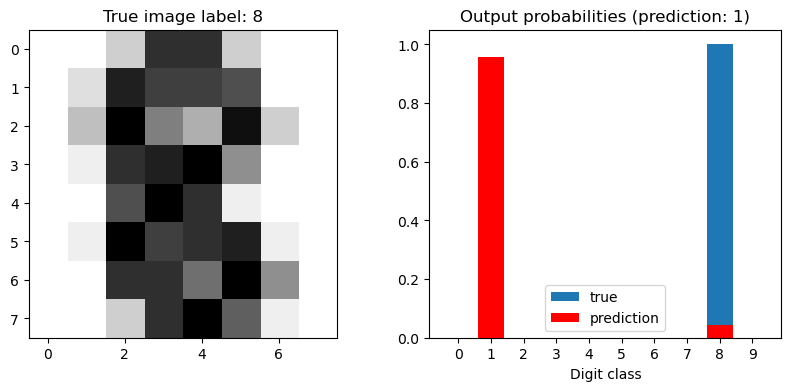

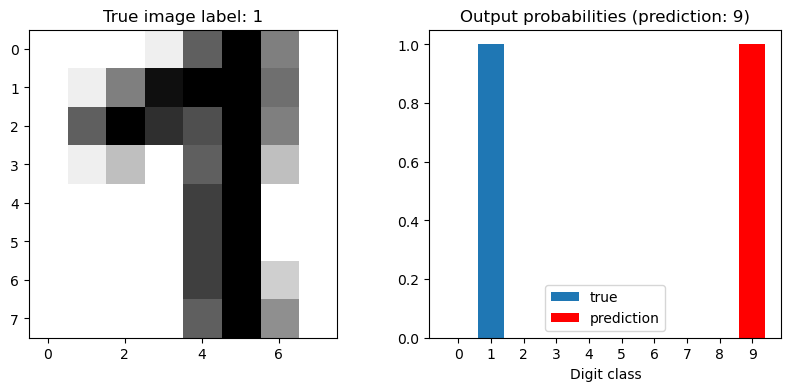

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Load dataset and split into train/test
digits = load_digits()
data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15, random_state=37)

# Define the necessary functions
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

def softmax(X):
    X_max = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - X_max)
    return exp / np.sum(exp, axis=-1, keepdims=True)

def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)
    loss = -np.sum(Y_true * np.log(Y_pred))
    return loss

# Define the LogisticRegression class
class LogisticRegression:
    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size), high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size, high=0.1, low=-0.1)
        self.output_size = output_size
        self.input_size = input_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
            
    def loss(self, X, y):
        y_onehot = one_hot(self.output_size, y)
        y_pred = self.forward(X)
        return nll(y_onehot, y_pred)

    def grad_loss(self, X, y_true, y_pred):
        grad_W = np.dot(X.T, (y_pred - y_true))
        grad_b = np.sum(y_pred - y_true, axis=0)
        return grad_W, grad_b

# Training the model
lr = LogisticRegression(input_size=X_train.shape[1], output_size=10)
learning_rate = 0.01
for i in range(len(X_train)):
    x = X_train[i:i+1]
    y = y_train[i:i+1]
    y_pred = lr.forward(x)
    grad_W, grad_b = lr.grad_loss(x, one_hot(lr.output_size, y), y_pred)
    lr.W -= learning_rate * grad_W
    lr.b -= learning_rate * grad_b
    if i % 100 == 0:
        avg_nll = lr.loss(X_train[max(0, i-100):i], y_train[max(0, i-100):i])
        print("Average NLL over the last 100 samples at step %d: %.5f" % (i, avg_nll))

# Define the plot_prediction function
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    ax0.imshow(X_test[sample_idx:sample_idx+1].reshape(8, 8),
               cmap=plt.cm.gray_r, interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx])
    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')
    ax1.bar(classes, model.forward(X_test[sample_idx]), label='prediction', color="red")
    ax1.set_xticks(classes)
    prediction = model.predict(X_test[sample_idx])
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

# Find the worst prediction errors
y_pred_test = lr.predict(X_test)
errors = np.abs(y_pred_test - y_test)

# Identify the indices of the worst predictions
worst_indices = np.argsort(errors)[-5:]  # Get top 5 worst predictions

# Plot the worst predictions
for idx in worst_indices:
    plot_prediction(lr, sample_idx=idx)
    plt.show()
